# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [11]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 64
IS_SAVE = True

utils.set_seed(SEED)

In [12]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [13]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_allwifibase_withdelta.csv')

In [14]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [15]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [16]:
bad_index = np.load('../54/output/oof54_badindex.npy')

In [17]:
train_df = train_df.drop(bad_index).reset_index(drop=True)

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [18]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61421
BSSID TYPES(test): 28283
BSSID TYPES(all): 89704


In [19]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 96
RSSI TYPES(test): 82
RSSI TYPES(all): 178


## PreProcess

In [20]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(output_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025864,-0.014953
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5825,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504875,0.397922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245037,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121380,0.362122
245038,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.383524,0.568957
245039,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd

In [21]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [22]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [23]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [24]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [25]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [26]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [27]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [28]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.0708999633789


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10620.098


epoch = 0, mpe_loss = 127.61101211818793


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3308.094 >= min_delta = 0.0. New best score: 7312.003


epoch = 1, mpe_loss = 101.91320068855596


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1841.100 >= min_delta = 0.0. New best score: 5470.904


epoch = 2, mpe_loss = 87.33106559116557


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1319.354 >= min_delta = 0.0. New best score: 4151.549


epoch = 3, mpe_loss = 72.56814177604872


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 996.790 >= min_delta = 0.0. New best score: 3154.759


epoch = 4, mpe_loss = 62.54688440391149


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 542.194 >= min_delta = 0.0. New best score: 2612.565


epoch = 5, mpe_loss = 57.04640745443595


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 289.517 >= min_delta = 0.0. New best score: 2323.049


epoch = 6, mpe_loss = 53.781413963708985


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 273.340 >= min_delta = 0.0. New best score: 2049.708


epoch = 7, mpe_loss = 49.591685369570406


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 744.179 >= min_delta = 0.0. New best score: 1305.529


epoch = 8, mpe_loss = 37.19738098968227


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 324.919 >= min_delta = 0.0. New best score: 980.610


epoch = 9, mpe_loss = 31.00465083544924


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 227.843 >= min_delta = 0.0. New best score: 752.767


epoch = 10, mpe_loss = 25.545843638540287


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 163.065 >= min_delta = 0.0. New best score: 589.702


epoch = 11, mpe_loss = 21.80375258759162


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 124.559 >= min_delta = 0.0. New best score: 465.144


epoch = 12, mpe_loss = 18.636001604211256


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 95.580 >= min_delta = 0.0. New best score: 369.563


epoch = 13, mpe_loss = 16.238149948895998


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 67.486 >= min_delta = 0.0. New best score: 302.077


epoch = 14, mpe_loss = 14.80619924928061


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 56.122 >= min_delta = 0.0. New best score: 245.955


epoch = 15, mpe_loss = 13.250367218280227


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 25.551 >= min_delta = 0.0. New best score: 220.404


epoch = 16, mpe_loss = 13.20824276333525


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 47.924 >= min_delta = 0.0. New best score: 172.480


epoch = 17, mpe_loss = 11.07771868753401


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 24.524 >= min_delta = 0.0. New best score: 147.955


epoch = 18, mpe_loss = 10.372525127761087


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 20.647 >= min_delta = 0.0. New best score: 127.308


epoch = 19, mpe_loss = 9.717934627156593


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.657 >= min_delta = 0.0. New best score: 113.651


epoch = 20, mpe_loss = 9.494436452651518


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.728 >= min_delta = 0.0. New best score: 109.923


epoch = 21, mpe_loss = 9.676564071613491


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 16.978 >= min_delta = 0.0. New best score: 92.945


epoch = 22, mpe_loss = 9.155823175325088


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.749 >= min_delta = 0.0. New best score: 79.196


epoch = 23, mpe_loss = 8.450313593785076


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.651 >= min_delta = 0.0. New best score: 76.546


epoch = 24, mpe_loss = 8.685797244902657


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 13.42563539910338


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 15.579 >= min_delta = 0.0. New best score: 60.966


epoch = 26, mpe_loss = 7.988082278307861


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.647 >= min_delta = 0.0. New best score: 55.319


epoch = 27, mpe_loss = 7.7548682753875005


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.899 >= min_delta = 0.0. New best score: 54.420


epoch = 28, mpe_loss = 7.813429139641997


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.509 >= min_delta = 0.0. New best score: 50.911


epoch = 29, mpe_loss = 7.742674217516491


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.287 >= min_delta = 0.0. New best score: 49.624


epoch = 30, mpe_loss = 7.657074756415557


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.116791285244645


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.697 >= min_delta = 0.0. New best score: 47.927


epoch = 32, mpe_loss = 7.652693543088468


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.105 >= min_delta = 0.0. New best score: 43.821


epoch = 33, mpe_loss = 7.375154715566455


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.48434064018371


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.563668223792837


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.851352735923126


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.409 >= min_delta = 0.0. New best score: 39.412


epoch = 37, mpe_loss = 7.246458360361643


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.559791255288007


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.861547082016463


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.402 >= min_delta = 0.0. New best score: 39.011


epoch = 40, mpe_loss = 7.309755353571707


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.967 >= min_delta = 0.0. New best score: 38.044


epoch = 41, mpe_loss = 7.1532196789279965


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.217809294512816


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.757 >= min_delta = 0.0. New best score: 37.287


epoch = 43, mpe_loss = 7.135783762426233


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.3018508379725375


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.500788204432503


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.374632030644714


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.431601130892375


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.196 >= min_delta = 0.0. New best score: 34.091


epoch = 48, mpe_loss = 6.739481962995154


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.163 >= min_delta = 0.0. New best score: 32.928


epoch = 49, mpe_loss = 6.630904567085523


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.559 >= min_delta = 0.0. New best score: 32.369


epoch = 50, mpe_loss = 6.576592832298945


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.796 >= min_delta = 0.0. New best score: 31.573


epoch = 51, mpe_loss = 6.524896318639789


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.179 >= min_delta = 0.0. New best score: 31.394


epoch = 52, mpe_loss = 6.498217809423736


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.018 >= min_delta = 0.0. New best score: 31.376


epoch = 53, mpe_loss = 6.497318254374876


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.104 >= min_delta = 0.0. New best score: 31.272


epoch = 54, mpe_loss = 6.499643745030383


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.443 >= min_delta = 0.0. New best score: 30.829


epoch = 55, mpe_loss = 6.447241459570172


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.4535555673835505


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.072 >= min_delta = 0.0. New best score: 30.757


epoch = 57, mpe_loss = 6.439396358090903


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.339 >= min_delta = 0.0. New best score: 30.418


epoch = 58, mpe_loss = 6.413842449121198


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.442510165179917


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.424321366162751


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.462557731537854


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.442235915654936


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.125 >= min_delta = 0.0. New best score: 30.292


epoch = 63, mpe_loss = 6.393814618254203


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.035 >= min_delta = 0.0. New best score: 30.257


epoch = 64, mpe_loss = 6.392056650067356


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.386851436898529


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.095 >= min_delta = 0.0. New best score: 30.162


epoch = 66, mpe_loss = 6.383671929223535


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.086 >= min_delta = 0.0. New best score: 30.076


epoch = 67, mpe_loss = 6.374251848859031


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.379021226215599


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.096 >= min_delta = 0.0. New best score: 29.980


epoch = 69, mpe_loss = 6.369076877818952


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.3715783445586895


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.376879922056262


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.37230313311532


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.371478654397104


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.372449199883595


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.370699433473551


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.369498048317571


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.367929103184413


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.006 >= min_delta = 0.0. New best score: 29.974


epoch = 78, mpe_loss = 6.369445500483143


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.373190881988974


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.377717772446566


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.373377516461905


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.372130643855695


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.373429076471841


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.368898964099176


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.369345261906329


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.372737969432528


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.370610877925357


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.372424433871013


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.372447349285907


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.36848647398462


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.372620762424256


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.375012886529585


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.376281131398817


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.374524023171848


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.371569331725277


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.371354612043125


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.3716025152045965


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 29.974. Signaling Trainer to stop.


epoch = 98, mpe_loss = 6.372797997488347
fold 0: mean position error 6.36828153589715
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,30.05139
Loss/xy,30.05139
Loss/floor,4.99254
MPE/val,6.36828
epoch,98
trainer/global_step,37916
_runtime,461
_timestamp,1621149475
_step,98


Loss/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▃▃▇█▃▃▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 155.7163543701172


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 11168.780


epoch = 0, mpe_loss = 132.57439659292243


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3254.969 >= min_delta = 0.0. New best score: 7913.812


epoch = 1, mpe_loss = 107.6745341963992


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1971.272 >= min_delta = 0.0. New best score: 5942.539


epoch = 2, mpe_loss = 92.21702770451327


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1977.858 >= min_delta = 0.0. New best score: 3964.681


epoch = 3, mpe_loss = 71.84986526705494


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 944.578 >= min_delta = 0.0. New best score: 3020.103


epoch = 4, mpe_loss = 61.61964457284898


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 573.152 >= min_delta = 0.0. New best score: 2446.952


epoch = 5, mpe_loss = 54.7810345307706


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 432.801 >= min_delta = 0.0. New best score: 2014.150


epoch = 6, mpe_loss = 48.70338651844802


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 299.885 >= min_delta = 0.0. New best score: 1714.265


epoch = 7, mpe_loss = 43.93396112328191


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 280.368 >= min_delta = 0.0. New best score: 1433.897


epoch = 8, mpe_loss = 38.89166946061689


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 243.395 >= min_delta = 0.0. New best score: 1190.502


epoch = 9, mpe_loss = 33.730783032342565


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 200.922 >= min_delta = 0.0. New best score: 989.580


epoch = 10, mpe_loss = 29.670569013464313


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 169.783 >= min_delta = 0.0. New best score: 819.796


epoch = 11, mpe_loss = 26.25385165416451


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 140.984 >= min_delta = 0.0. New best score: 678.813


epoch = 12, mpe_loss = 23.32057004958364


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 120.619 >= min_delta = 0.0. New best score: 558.194


epoch = 13, mpe_loss = 20.756121039107885


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 98.771 >= min_delta = 0.0. New best score: 459.423


epoch = 14, mpe_loss = 18.595848666175915


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 84.536 >= min_delta = 0.0. New best score: 374.887


epoch = 15, mpe_loss = 16.438385919274893


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 95.344 >= min_delta = 0.0. New best score: 279.543


epoch = 16, mpe_loss = 14.115851869306914


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 29.421 >= min_delta = 0.0. New best score: 250.122


epoch = 17, mpe_loss = 13.756361209051287


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 65.297 >= min_delta = 0.0. New best score: 184.825


epoch = 18, mpe_loss = 11.515535230303305


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 31.111 >= min_delta = 0.0. New best score: 153.714


epoch = 19, mpe_loss = 10.508573197144695


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 21.260 >= min_delta = 0.0. New best score: 132.454


epoch = 20, mpe_loss = 9.94272408566447


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 15.829 >= min_delta = 0.0. New best score: 116.625


epoch = 21, mpe_loss = 9.519968171577897


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 9.599 >= min_delta = 0.0. New best score: 107.026


epoch = 22, mpe_loss = 9.46308387098489


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 10.278269933087392


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 24.181 >= min_delta = 0.0. New best score: 82.844


epoch = 24, mpe_loss = 8.787237891040627


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.226 >= min_delta = 0.0. New best score: 69.619


epoch = 25, mpe_loss = 8.205799491021045


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 8.201 >= min_delta = 0.0. New best score: 61.418


epoch = 26, mpe_loss = 7.970921102887677


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.998 >= min_delta = 0.0. New best score: 56.420


epoch = 27, mpe_loss = 7.889109683876761


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.806 >= min_delta = 0.0. New best score: 54.614


epoch = 28, mpe_loss = 7.957682151323842


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.218 >= min_delta = 0.0. New best score: 52.396


epoch = 29, mpe_loss = 7.93390443159205


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.123 >= min_delta = 0.0. New best score: 49.273


epoch = 30, mpe_loss = 7.7547923824947596


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 7.8896291116496515


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.600 >= min_delta = 0.0. New best score: 46.673


epoch = 32, mpe_loss = 7.604661109028577


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.949631188512386


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.965 >= min_delta = 0.0. New best score: 44.708


epoch = 34, mpe_loss = 7.609567298367956


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.396 >= min_delta = 0.0. New best score: 44.312


epoch = 35, mpe_loss = 7.688157865550459


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.343 >= min_delta = 0.0. New best score: 40.969


epoch = 36, mpe_loss = 7.387135080353786


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.947 >= min_delta = 0.0. New best score: 39.022


epoch = 37, mpe_loss = 7.203270514119609


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.235 >= min_delta = 0.0. New best score: 38.787


epoch = 38, mpe_loss = 7.247607441358234


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.425007115225051


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.618524754219692


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.95847251534785


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.664 >= min_delta = 0.0. New best score: 38.122


epoch = 42, mpe_loss = 7.212825261278527


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.535902005089437


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.485 >= min_delta = 0.0. New best score: 37.637


epoch = 44, mpe_loss = 7.175974199280829


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.3580635353020964


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.756354727598063


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.734720856099379


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.5873463855822445


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.333 >= min_delta = 0.0. New best score: 34.304


epoch = 49, mpe_loss = 6.7513690262548325


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.677 >= min_delta = 0.0. New best score: 33.627


epoch = 50, mpe_loss = 6.665680295103773


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.329 >= min_delta = 0.0. New best score: 33.298


epoch = 51, mpe_loss = 6.626820123615627


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.315 >= min_delta = 0.0. New best score: 32.983


epoch = 52, mpe_loss = 6.5872147733643445


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.425 >= min_delta = 0.0. New best score: 32.558


epoch = 53, mpe_loss = 6.554686699705342


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.134 >= min_delta = 0.0. New best score: 32.424


epoch = 54, mpe_loss = 6.537439552621198


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.081 >= min_delta = 0.0. New best score: 32.343


epoch = 55, mpe_loss = 6.534493112096996


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.088 >= min_delta = 0.0. New best score: 32.255


epoch = 56, mpe_loss = 6.5294235325145


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.154 >= min_delta = 0.0. New best score: 32.101


epoch = 57, mpe_loss = 6.512921752645394


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.5292524531914395


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.5312152777907


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.5213081959598


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.532333366875726


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.179 >= min_delta = 0.0. New best score: 31.922


epoch = 62, mpe_loss = 6.487518580948435


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.070 >= min_delta = 0.0. New best score: 31.852


epoch = 63, mpe_loss = 6.482726989218051


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.013 >= min_delta = 0.0. New best score: 31.839


epoch = 64, mpe_loss = 6.477081988905343


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.045 >= min_delta = 0.0. New best score: 31.794


epoch = 65, mpe_loss = 6.4731544485314


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.466868409215596


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.095 >= min_delta = 0.0. New best score: 31.699


epoch = 67, mpe_loss = 6.46288737069139


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.463642893875625


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.010 >= min_delta = 0.0. New best score: 31.690


epoch = 69, mpe_loss = 6.46212180363992


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.092 >= min_delta = 0.0. New best score: 31.598


epoch = 70, mpe_loss = 6.4557713871483555


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.463930601188484


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.462105882953931


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.458503151697787


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.465062512116812


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.455928175194423


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.047 >= min_delta = 0.0. New best score: 31.551


epoch = 76, mpe_loss = 6.452793983505347


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.038 >= min_delta = 0.0. New best score: 31.513


epoch = 77, mpe_loss = 6.449304094745052


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.455194906234849


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.454001236703607


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.4533269506455975


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.454902217936279


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.454099775848081


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.451218910582614


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.454504217074169


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.45646137059704


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.45214445156726


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.45095058101841


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.4537722749909845


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.450118326922742


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.012 >= min_delta = 0.0. New best score: 31.501


epoch = 90, mpe_loss = 6.445593905938888


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.451914813628633


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.456199598997536


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.449974127840704


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.005 >= min_delta = 0.0. New best score: 31.497


epoch = 94, mpe_loss = 6.444614924887547


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.450132337709268


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.45467584356733


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.452930632605139


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.456373554352392


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.452417101552871


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.449713024720482


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.45269291351912


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.452083060889763


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.460924919139401


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.4524493191017696


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.450885914441101


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.447436406784426


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.448799097582415


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.454867240327538


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.4545726073533976


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.452202059294904


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.455270952715892


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.450943957721477


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.458608448054463


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 31.497. Signaling Trainer to stop.


epoch = 114, mpe_loss = 6.450781250387673
fold 1: mean position error 6.439239660248204
Fold 2


Loss/val,31.56039
Loss/xy,31.56039
Loss/floor,4.69363
MPE/val,6.43924
epoch,114
trainer/global_step,44044
_runtime,546
_timestamp,1621150028
_step,114


Loss/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▆▆▄▂▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 138.61230850219727


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10319.191


epoch = 0, mpe_loss = 126.03974019271739


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3260.496 >= min_delta = 0.0. New best score: 7058.695


epoch = 1, mpe_loss = 100.91091124216716


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1802.844 >= min_delta = 0.0. New best score: 5255.851


epoch = 2, mpe_loss = 86.99962206422418


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 865.969 >= min_delta = 0.0. New best score: 4389.882


epoch = 3, mpe_loss = 80.8896404141965


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 341.229 >= min_delta = 0.0. New best score: 4048.653


epoch = 4, mpe_loss = 79.03484843260999


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 100.219 >= min_delta = 0.0. New best score: 3948.434


epoch = 5, mpe_loss = 78.90218867426334


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 17.377 >= min_delta = 0.0. New best score: 3931.057


epoch = 6, mpe_loss = 79.16017966512321


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 79.35561317982881


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 79.44009587730187


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1663.931 >= min_delta = 0.0. New best score: 2267.126


epoch = 9, mpe_loss = 53.637154595575474


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 255.430 >= min_delta = 0.0. New best score: 2011.696


epoch = 10, mpe_loss = 50.31822606618854


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 118.910 >= min_delta = 0.0. New best score: 1892.785


epoch = 11, mpe_loss = 48.78436464071274


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 84.821 >= min_delta = 0.0. New best score: 1807.964


epoch = 12, mpe_loss = 47.53696698641431


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 221.879 >= min_delta = 0.0. New best score: 1586.085


epoch = 13, mpe_loss = 44.14381785150888


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 483.083 >= min_delta = 0.0. New best score: 1103.002


epoch = 14, mpe_loss = 34.883126908454344


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 295.005 >= min_delta = 0.0. New best score: 807.997


epoch = 15, mpe_loss = 28.163080952305723


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 204.263 >= min_delta = 0.0. New best score: 603.734


epoch = 16, mpe_loss = 23.092218736159627


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 142.540 >= min_delta = 0.0. New best score: 461.194


epoch = 17, mpe_loss = 19.451206306400508


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 101.570 >= min_delta = 0.0. New best score: 359.624


epoch = 18, mpe_loss = 16.826027107411537


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 73.551 >= min_delta = 0.0. New best score: 286.074


epoch = 19, mpe_loss = 14.980845242522767


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 55.484 >= min_delta = 0.0. New best score: 230.589


epoch = 20, mpe_loss = 13.412392145265704


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 39.412 >= min_delta = 0.0. New best score: 191.178


epoch = 21, mpe_loss = 12.434651097093804


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 27.112 >= min_delta = 0.0. New best score: 164.066


epoch = 22, mpe_loss = 11.761992747800937


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 21.084 >= min_delta = 0.0. New best score: 142.982


epoch = 23, mpe_loss = 11.144779810654944


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 27.076 >= min_delta = 0.0. New best score: 115.905


epoch = 24, mpe_loss = 9.958320179927176


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 8.588 >= min_delta = 0.0. New best score: 107.317


epoch = 25, mpe_loss = 9.809836145544397


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.403 >= min_delta = 0.0. New best score: 93.914


epoch = 26, mpe_loss = 9.228974356383517


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 8.145 >= min_delta = 0.0. New best score: 85.769


epoch = 27, mpe_loss = 9.15025316891463


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 8.576 >= min_delta = 0.0. New best score: 77.193


epoch = 28, mpe_loss = 8.995155854285628


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 10.0792656024729


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 14.491 >= min_delta = 0.0. New best score: 62.702


epoch = 30, mpe_loss = 8.438118842200957


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.309 >= min_delta = 0.0. New best score: 59.393


epoch = 31, mpe_loss = 8.272437849554462


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.113 >= min_delta = 0.0. New best score: 55.280


epoch = 32, mpe_loss = 8.209442275589792


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.402930569605552


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.767 >= min_delta = 0.0. New best score: 48.513


epoch = 34, mpe_loss = 7.854678873134696


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.062295258909032


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.821 >= min_delta = 0.0. New best score: 44.693


epoch = 36, mpe_loss = 7.659511080686596


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.040661702121513


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.653564948102702


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.622 >= min_delta = 0.0. New best score: 44.070


epoch = 39, mpe_loss = 7.659272488044656


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.733553567226383


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.003 >= min_delta = 0.0. New best score: 41.068


epoch = 41, mpe_loss = 7.4213204623564435


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.513 >= min_delta = 0.0. New best score: 39.555


epoch = 42, mpe_loss = 7.3033681200898215


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.178 >= min_delta = 0.0. New best score: 39.377


epoch = 43, mpe_loss = 7.330419372173323


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.669007063991781


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.479169462470041


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.5272956011088


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.882256539403528


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.488 >= min_delta = 0.0. New best score: 34.889


epoch = 48, mpe_loss = 6.865773833316305


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.465 >= min_delta = 0.0. New best score: 33.425


epoch = 49, mpe_loss = 6.706963803673136


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.243 >= min_delta = 0.0. New best score: 33.182


epoch = 50, mpe_loss = 6.665982347251712


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.493 >= min_delta = 0.0. New best score: 32.689


epoch = 51, mpe_loss = 6.615637050158735


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.181 >= min_delta = 0.0. New best score: 32.507


epoch = 52, mpe_loss = 6.587502974962843


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.268 >= min_delta = 0.0. New best score: 32.240


epoch = 53, mpe_loss = 6.567911769816841


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.140 >= min_delta = 0.0. New best score: 32.100


epoch = 54, mpe_loss = 6.544991291951443


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.065 >= min_delta = 0.0. New best score: 32.035


epoch = 55, mpe_loss = 6.546098057558571


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.033 >= min_delta = 0.0. New best score: 32.002


epoch = 56, mpe_loss = 6.53670467371526


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.379 >= min_delta = 0.0. New best score: 31.622


epoch = 57, mpe_loss = 6.505757526858993


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.521935377000035


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.5230131924584285


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.526739898151246


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.517308409231297


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.490472562287164


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.154 >= min_delta = 0.0. New best score: 31.469


epoch = 63, mpe_loss = 6.47917405181173


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.481642264602841


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.482964285905811


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.138 >= min_delta = 0.0. New best score: 31.331


epoch = 66, mpe_loss = 6.471273881369743


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.46794718136822


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.470131976448971


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.473326428212982


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.035 >= min_delta = 0.0. New best score: 31.295


epoch = 70, mpe_loss = 6.467998404217803


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.4659554690554515


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.465905019122622


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.053 >= min_delta = 0.0. New best score: 31.243


epoch = 73, mpe_loss = 6.46568017701308


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.106 >= min_delta = 0.0. New best score: 31.136


epoch = 74, mpe_loss = 6.457152806762335


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.4578524793403735


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.453126973216084


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.034 >= min_delta = 0.0. New best score: 31.102


epoch = 77, mpe_loss = 6.447839077400125


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.454969987705134


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.460299388869949


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.455981187414433


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.032 >= min_delta = 0.0. New best score: 31.070


epoch = 81, mpe_loss = 6.450187314895616


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.462081553927367


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.450714659215747


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.045 >= min_delta = 0.0. New best score: 31.025


epoch = 84, mpe_loss = 6.442976183001545


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.444818954968798


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.449702091623043


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.445850579418998


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.445131548936817


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.444806135650995


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.051 >= min_delta = 0.0. New best score: 30.973


epoch = 90, mpe_loss = 6.439497886360556


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.4426860481068715


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.442083516846533


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.443766069800958


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.44070345962393


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.441639839847018


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.450489252589751


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.006 >= min_delta = 0.0. New best score: 30.967


epoch = 97, mpe_loss = 6.440596853477367


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.443084469308023


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.43798747205216


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.4420496160569405


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.439106850736383


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.4443186366039775


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.44452630566514


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.443238255770311


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.441754877999209


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.444869164107502


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.444253825191137


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.443420121851175


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.440877719417863


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.441176677095718


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.442894806032595


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.440591753824897


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.444353358469147


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.441289112619732


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.44083297079888


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.445416509025339


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 30.967. Signaling Trainer to stop.


epoch = 117, mpe_loss = 6.444120519403097
fold 2: mean position error 6.440418993344031
Fold 3


Loss/val,31.00998
Loss/xy,31.00998
Loss/floor,5.21029
MPE/val,6.44042
epoch,117
trainer/global_step,45193
_runtime,560
_timestamp,1621150596
_step,117


Loss/val,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▆█▆▇▇▇▇█▇████████████████████████████
MPE/val,█▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 143.2299346923828


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10750.477


epoch = 0, mpe_loss = 129.09982469116432


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3480.973 >= min_delta = 0.0. New best score: 7269.504


epoch = 1, mpe_loss = 103.12255651363428


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1820.025 >= min_delta = 0.0. New best score: 5449.479


epoch = 2, mpe_loss = 89.19680247185886


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 818.936 >= min_delta = 0.0. New best score: 4630.542


epoch = 3, mpe_loss = 83.46702289754066


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 308.573 >= min_delta = 0.0. New best score: 4321.969


epoch = 4, mpe_loss = 81.73755276030388


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 841.264 >= min_delta = 0.0. New best score: 3480.705


epoch = 5, mpe_loss = 68.89067807664041


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 717.100 >= min_delta = 0.0. New best score: 2763.605


epoch = 6, mpe_loss = 59.60033250978028


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 349.132 >= min_delta = 0.0. New best score: 2414.473


epoch = 7, mpe_loss = 55.20834272581598


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 214.852 >= min_delta = 0.0. New best score: 2199.621


epoch = 8, mpe_loss = 52.281048286652215


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 490.778 >= min_delta = 0.0. New best score: 1708.844


epoch = 9, mpe_loss = 44.26901491396669


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 442.737 >= min_delta = 0.0. New best score: 1266.107


epoch = 10, mpe_loss = 35.97019884335822


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 279.603 >= min_delta = 0.0. New best score: 986.504


epoch = 11, mpe_loss = 30.20515589437623


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 212.129 >= min_delta = 0.0. New best score: 774.375


epoch = 12, mpe_loss = 25.640942406827122


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 161.598 >= min_delta = 0.0. New best score: 612.777


epoch = 13, mpe_loss = 22.04749560377736


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 128.825 >= min_delta = 0.0. New best score: 483.952


epoch = 14, mpe_loss = 18.813252264390822


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 95.017 >= min_delta = 0.0. New best score: 388.935


epoch = 15, mpe_loss = 16.549543722816136


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 74.978 >= min_delta = 0.0. New best score: 313.956


epoch = 16, mpe_loss = 14.63157866657644


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 55.967 >= min_delta = 0.0. New best score: 257.990


epoch = 17, mpe_loss = 13.103885901578957


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 41.641 >= min_delta = 0.0. New best score: 216.349


epoch = 18, mpe_loss = 11.891907720462136


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 18.627 >= min_delta = 0.0. New best score: 197.722


epoch = 19, mpe_loss = 11.91463707085105


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 35.758 >= min_delta = 0.0. New best score: 161.964


epoch = 20, mpe_loss = 10.315855323836423


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 16.255 >= min_delta = 0.0. New best score: 145.708


epoch = 21, mpe_loss = 9.936470930775007


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 18.660 >= min_delta = 0.0. New best score: 127.048


epoch = 22, mpe_loss = 9.459184861701468


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 9.434 >= min_delta = 0.0. New best score: 117.614


epoch = 23, mpe_loss = 9.505083696565766


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 15.244 >= min_delta = 0.0. New best score: 102.371


epoch = 24, mpe_loss = 8.934641468136206


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 9.213 >= min_delta = 0.0. New best score: 93.157


epoch = 25, mpe_loss = 8.714973887887554


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.661 >= min_delta = 0.0. New best score: 90.496


epoch = 26, mpe_loss = 8.997221939157749


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.674 >= min_delta = 0.0. New best score: 78.823


epoch = 27, mpe_loss = 8.392812333677126


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 7.215 >= min_delta = 0.0. New best score: 71.608


epoch = 28, mpe_loss = 8.229279316637827


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.432 >= min_delta = 0.0. New best score: 65.176


epoch = 29, mpe_loss = 7.997365316835002


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.386580930887789


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.854 >= min_delta = 0.0. New best score: 62.322


epoch = 31, mpe_loss = 8.122180991414664


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.527194577498712


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 8.309 >= min_delta = 0.0. New best score: 54.013


epoch = 33, mpe_loss = 7.742468206346899


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.172 >= min_delta = 0.0. New best score: 50.841


epoch = 34, mpe_loss = 7.610811985705209


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.949304658217706


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.0353999895894


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.406 >= min_delta = 0.0. New best score: 45.435


epoch = 37, mpe_loss = 7.490497830337373


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.743600938631141


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.782 >= min_delta = 0.0. New best score: 43.654


epoch = 39, mpe_loss = 7.464988519748052


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.893301830775496


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.381332121897435


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.465 >= min_delta = 0.0. New best score: 40.189


epoch = 42, mpe_loss = 7.303343896848568


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.494 >= min_delta = 0.0. New best score: 39.695


epoch = 43, mpe_loss = 7.275013654128365


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.420526777272639


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.284328770594321


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.710390969678976


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.275924680025682


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.343 >= min_delta = 0.0. New best score: 34.351


epoch = 48, mpe_loss = 6.713496578128442


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.783 >= min_delta = 0.0. New best score: 33.568


epoch = 49, mpe_loss = 6.634119729416958


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.011 >= min_delta = 0.0. New best score: 33.557


epoch = 50, mpe_loss = 6.619603908580282


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.451 >= min_delta = 0.0. New best score: 33.106


epoch = 51, mpe_loss = 6.578126923761506


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.289 >= min_delta = 0.0. New best score: 32.816


epoch = 52, mpe_loss = 6.553837039656397


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.5593269149894295


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.372 >= min_delta = 0.0. New best score: 32.445


epoch = 54, mpe_loss = 6.538842576353446


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.533954073337541


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.131 >= min_delta = 0.0. New best score: 32.313


epoch = 56, mpe_loss = 6.505790304014648


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.019 >= min_delta = 0.0. New best score: 32.295


epoch = 57, mpe_loss = 6.523550306757291


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.527303469569787


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.120 >= min_delta = 0.0. New best score: 32.174


epoch = 59, mpe_loss = 6.5224651009708206


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.065 >= min_delta = 0.0. New best score: 32.110


epoch = 60, mpe_loss = 6.4942314659339795


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.453 >= min_delta = 0.0. New best score: 31.657


epoch = 61, mpe_loss = 6.475802119443382


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.481310643147732


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.499684737428375


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.209 >= min_delta = 0.0. New best score: 31.448


epoch = 64, mpe_loss = 6.466382392074752


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.4881668507620915


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.124 >= min_delta = 0.0. New best score: 31.324


epoch = 66, mpe_loss = 6.477463109121807


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.458447232842445


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.490562410674233


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.4581188969853995


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.147 >= min_delta = 0.0. New best score: 31.177


epoch = 70, mpe_loss = 6.463917563358943


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.094 >= min_delta = 0.0. New best score: 31.083


epoch = 71, mpe_loss = 6.460814066123272


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.192 >= min_delta = 0.0. New best score: 30.891


epoch = 72, mpe_loss = 6.459969542164733


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.455149003776952


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.458365557850271


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.354 >= min_delta = 0.0. New best score: 30.537


epoch = 75, mpe_loss = 6.443668412125629


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.454248411715895


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.4561434064222425


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.455397582572439


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.443732210907384


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.406942996641864


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.407989847919215


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.019 >= min_delta = 0.0. New best score: 30.518


epoch = 82, mpe_loss = 6.399242744497631


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.147 >= min_delta = 0.0. New best score: 30.371


epoch = 83, mpe_loss = 6.387143060349036


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.400438285608222


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.3956401885851575


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.4031017424835674


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.39364677451659


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.391452895342439


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.39235427522141


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.389301052775935


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.024 >= min_delta = 0.0. New best score: 30.347


epoch = 91, mpe_loss = 6.387715716508851


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.393267550546191


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.385951406281927


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.3910371136406185


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.387839491816535


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.390666972251906


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.39276336522206


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.388083436998769


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.386795115643653


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.388587965265565


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.390419647961423


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.390640814019286


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.387221785127252


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.009 >= min_delta = 0.0. New best score: 30.338


epoch = 104, mpe_loss = 6.38457875299281


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.385650455303814


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.39734533191591


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.384850755117942


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.383923979773037


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.020 >= min_delta = 0.0. New best score: 30.319


epoch = 109, mpe_loss = 6.385447701682215


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.387272042856701


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.38851595831954


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.387738337335379


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.387206291158994


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.385692420213118


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.382773361560228


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.385776005145433


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 6.383402456192003


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.3881222763355225


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.391229603817497


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.38486775431944


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.389488029739131


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 6.394188683102096


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 6.390033287846523


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 6.388852859752766


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 6.387958436988402


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 6.38798458982205


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 6.390149279996969


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 6.386733890875526


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 30.319. Signaling Trainer to stop.


epoch = 129, mpe_loss = 6.394349275507789
fold 3: mean position error 6.3935055293442105
Fold 4


Loss/val,30.53283
Loss/xy,30.53283
Loss/floor,5.46422
MPE/val,6.39351
epoch,129
trainer/global_step,49789
_runtime,621
_timestamp,1621151225
_step,129


Loss/val,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,███▇▅▅▅▄▃▂▁▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 147.02399444580078


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 12731.813


epoch = 0, mpe_loss = 142.50947593778804


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2748.163 >= min_delta = 0.0. New best score: 9983.650


epoch = 1, mpe_loss = 122.70165564011836


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2033.287 >= min_delta = 0.0. New best score: 7950.363


epoch = 2, mpe_loss = 107.11175369870836


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1454.204 >= min_delta = 0.0. New best score: 6496.159


epoch = 3, mpe_loss = 95.81742170323496


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 992.356 >= min_delta = 0.0. New best score: 5503.803


epoch = 4, mpe_loss = 88.42661145977353


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 636.996 >= min_delta = 0.0. New best score: 4866.807


epoch = 5, mpe_loss = 84.06995847259742


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 376.146 >= min_delta = 0.0. New best score: 4490.661


epoch = 6, mpe_loss = 81.92634910776995


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 199.708 >= min_delta = 0.0. New best score: 4290.953


epoch = 7, mpe_loss = 81.13457301906918


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 91.799 >= min_delta = 0.0. New best score: 4199.153


epoch = 8, mpe_loss = 81.02228398426719


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1183.702 >= min_delta = 0.0. New best score: 3015.451


epoch = 9, mpe_loss = 61.698719922183216


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 839.799 >= min_delta = 0.0. New best score: 2175.653


epoch = 10, mpe_loss = 49.99493552852368


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 438.823 >= min_delta = 0.0. New best score: 1736.829


epoch = 11, mpe_loss = 43.668210649835885


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 277.464 >= min_delta = 0.0. New best score: 1459.365


epoch = 12, mpe_loss = 39.632527308187626


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 272.242 >= min_delta = 0.0. New best score: 1187.123


epoch = 13, mpe_loss = 35.43395749468734


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 203.236 >= min_delta = 0.0. New best score: 983.886


epoch = 14, mpe_loss = 31.660711991614193


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 156.381 >= min_delta = 0.0. New best score: 827.505


epoch = 15, mpe_loss = 28.87943737446398


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 214.681 >= min_delta = 0.0. New best score: 612.825


epoch = 16, mpe_loss = 23.957123502441075


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 121.605 >= min_delta = 0.0. New best score: 491.220


epoch = 17, mpe_loss = 21.389319729977757


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 116.877 >= min_delta = 0.0. New best score: 374.344


epoch = 18, mpe_loss = 17.64093935597634


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 75.194 >= min_delta = 0.0. New best score: 299.149


epoch = 19, mpe_loss = 15.297199232638746


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 54.395 >= min_delta = 0.0. New best score: 244.754


epoch = 20, mpe_loss = 13.667779361856157


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 38.935 >= min_delta = 0.0. New best score: 205.819


epoch = 21, mpe_loss = 12.671535001284832


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 27.301 >= min_delta = 0.0. New best score: 178.518


epoch = 22, mpe_loss = 12.030460377534231


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 13.471193428272786


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 42.714 >= min_delta = 0.0. New best score: 135.804


epoch = 24, mpe_loss = 11.154150457485862


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 16.561 >= min_delta = 0.0. New best score: 119.242


epoch = 25, mpe_loss = 10.652316352811413


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 19.640 >= min_delta = 0.0. New best score: 99.603


epoch = 26, mpe_loss = 9.727778123772664


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.695 >= min_delta = 0.0. New best score: 92.907


epoch = 27, mpe_loss = 9.86929576660412


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.571 >= min_delta = 0.0. New best score: 90.336


epoch = 28, mpe_loss = 10.025406186563382


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 19.743 >= min_delta = 0.0. New best score: 70.593


epoch = 29, mpe_loss = 8.922235325410746


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 10.301 >= min_delta = 0.0. New best score: 60.292


epoch = 30, mpe_loss = 8.269942748589791


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.606417070048442


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 7.297 >= min_delta = 0.0. New best score: 52.995


epoch = 32, mpe_loss = 8.068318187542584


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.148 >= min_delta = 0.0. New best score: 51.848


epoch = 33, mpe_loss = 8.061489615967309


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 10.1252625990605


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.153 >= min_delta = 0.0. New best score: 47.695


epoch = 35, mpe_loss = 7.743807677341544


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.552 >= min_delta = 0.0. New best score: 46.144


epoch = 36, mpe_loss = 7.725221262677856


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.265 >= min_delta = 0.0. New best score: 43.879


epoch = 37, mpe_loss = 7.658313496173292


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.325 >= min_delta = 0.0. New best score: 42.554


epoch = 38, mpe_loss = 7.506924099248388


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.871512995249983


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.659886270329572


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.817 >= min_delta = 0.0. New best score: 40.738


epoch = 41, mpe_loss = 7.475297171136607


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.928289102687351


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.709854621170224


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.724 >= min_delta = 0.0. New best score: 40.014


epoch = 44, mpe_loss = 7.33476426527984


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.595 >= min_delta = 0.0. New best score: 38.419


epoch = 45, mpe_loss = 7.201701195343681


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.285494850381561


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.695701193118441


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.371281082431476


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.33679628264213


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.877 >= min_delta = 0.0. New best score: 32.542


epoch = 50, mpe_loss = 6.662066798711169


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.943 >= min_delta = 0.0. New best score: 31.598


epoch = 51, mpe_loss = 6.561718200751836


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.488 >= min_delta = 0.0. New best score: 31.110


epoch = 52, mpe_loss = 6.512441003236218


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.288 >= min_delta = 0.0. New best score: 30.822


epoch = 53, mpe_loss = 6.47932836510565


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.4700124838213995


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 6.471001101468784


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.302 >= min_delta = 0.0. New best score: 30.520


epoch = 56, mpe_loss = 6.43751649968866


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.4591953704754514


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.439020518699418


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.211 >= min_delta = 0.0. New best score: 30.309


epoch = 59, mpe_loss = 6.4262915459879935


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.000 >= min_delta = 0.0. New best score: 30.308


epoch = 60, mpe_loss = 6.41218560113423


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.074 >= min_delta = 0.0. New best score: 30.234


epoch = 61, mpe_loss = 6.411849512462166


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.140 >= min_delta = 0.0. New best score: 30.094


epoch = 62, mpe_loss = 6.410692953761074


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.094 >= min_delta = 0.0. New best score: 30.000


epoch = 63, mpe_loss = 6.396653136913327


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.405339820445448


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.418746283520822


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.412935521939526


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.395157706478368


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.281 >= min_delta = 0.0. New best score: 29.719


epoch = 68, mpe_loss = 6.357154724282631


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.079 >= min_delta = 0.0. New best score: 29.641


epoch = 69, mpe_loss = 6.347609525789385


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.3568341469635135


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.354444980837297


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.356643814539564


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.353567570663881


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.350422589243323


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.350803640441619


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.349240197867587


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.000 >= min_delta = 0.0. New best score: 29.640


epoch = 77, mpe_loss = 6.3452555215445114


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.354263880654521


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.346370112528835


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.023 >= min_delta = 0.0. New best score: 29.617


epoch = 80, mpe_loss = 6.342727038523425


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.350135533166104


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.351155048695163


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.3476348908051206


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.355852277814478


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.348427229385446


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.347528912882875


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.3501933346623956


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.003 >= min_delta = 0.0. New best score: 29.614


epoch = 88, mpe_loss = 6.342584881877554


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.34684545935496


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.357524739875309


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.342733924587567


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.351166913474816


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.3520100856388835


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.354893577703531


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.344884009572907


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.345073313600775


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.349065227353054


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.35046626865


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.356418776339379


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.347466223589752


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.346974024306173


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.343162905370844


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.348266731137815


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.344403514179631


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.34642847692189


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.004 >= min_delta = 0.0. New best score: 29.610


epoch = 106, mpe_loss = 6.342273117947406


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.351274043105651


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.347455437632575


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.346412170408429


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.345787126085033


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.349223206440608


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.348989932001501


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.018 >= min_delta = 0.0. New best score: 29.592


epoch = 113, mpe_loss = 6.340635888170506


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.346219598059204


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.350861628202424


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.3436375912548835


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 6.354818481358065


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.347792668403059


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.346054582384185


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.351769899328549


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.344582380699939


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 6.3453299998157275


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 6.348991719708927


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 6.346435662089051


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 6.348602740876917


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 6.346750290929407


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 6.342324842145477


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 6.350294505556424


Validating: 0it [00:00, ?it/s]

epoch = 129, mpe_loss = 6.354471483740254


Validating: 0it [00:00, ?it/s]

epoch = 130, mpe_loss = 6.350296394548554


Validating: 0it [00:00, ?it/s]

epoch = 131, mpe_loss = 6.339840458571047


Validating: 0it [00:00, ?it/s]

epoch = 132, mpe_loss = 6.346516573018786


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 29.592. Signaling Trainer to stop.


epoch = 133, mpe_loss = 6.345933375475199
fold 4: mean position error 6.342538870783031


In [29]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,159.352814,101.794701,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,160.993744,104.640236,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,163.330017,111.482979,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,161.314026,109.126778,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,161.720459,113.572899,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
245037,194.396606,141.506165,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245038,192.131561,140.078705,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245039,188.804718,141.774933,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245040,186.041199,140.899597,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [30]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [31]:
oofs_df_dupli[['path', 'timestamp', 'site']]

,path,timestamp,site
0,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b
1,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b
2,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b
3,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b
4,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b
...,...,...,...
69804,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266
69805,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266
69806,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266
69807,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266


In [32]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

,x,y,path,timestamp,site,site_path_timestamp,floor
0,166.566803,44.660553,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
1,186.502625,31.555155,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
2,194.196045,89.141129,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
3,186.586304,85.181961,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
4,185.613525,85.518547,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0
...,...,...,...,...,...,...,...
69804,65.325844,179.779037,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69805,61.390366,181.232864,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69806,49.017262,181.893250,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69807,43.259327,181.023285,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0


In [33]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [34]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

CV:6.396796974759953, CV_gby:6.02769702914384


In [35]:
fold_mean_xy = 0
for i in range(len(predictions)):
    fold_mean_xy += predictions[i][['x', 'y']]
fold_mean_xy = fold_mean_xy / 5
fold_mean_xy

,x,y
0,86.302322,104.407082
1,80.084610,106.639366
2,79.747246,103.531395
3,80.010201,105.480530
4,84.389572,105.519386
...,...,...
37395,205.089066,109.538719
37396,200.784271,109.312477
37397,201.929428,111.270973
37398,200.167068,112.466537


In [36]:
fold_mean_xy['site_path_timestamp'] = predictions[0]['site_path_timestamp']

In [37]:
all_preds = fold_mean_xy.groupby('site_path_timestamp').mean()

In [38]:
all_preds

,x,y
site_path_timestamp,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,86.302322,104.407082
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,79.947350,105.217094
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,84.385834,104.322235
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,86.457062,107.022903
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,83.689087,108.117142
...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,207.687775,99.277092
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,208.568970,101.596756
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,203.008270,108.929108


In [39]:
# all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
# all_preds

In [40]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.71397,104.649240
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.89932,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.22545,105.812570
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.35129,107.935360
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.31835,108.258490
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,210.10178,100.415660
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.61255,101.582490
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,205.28879,106.346170


In [41]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,86.302322,104.407082
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,79.947350,105.217094
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,84.385834,104.322235
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,86.457062,107.022903
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,83.689087,108.117142
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,207.687775,99.277092
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.568970,101.596756
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.008270,108.929108


In [42]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,86.302322,104.407082
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,79.947350,105.217094
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,84.385834,104.322235
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,86.457062,107.022903
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,83.689087,108.117142
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,207.687775,99.277092
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.568970,101.596756
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,203.008270,108.929108


In [43]:
raw_site = all_preds_merge.index

In [44]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,86.302322,104.407082
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,79.947350,105.217094
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.385834,104.322235
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.457062,107.022903
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,83.689087,108.117142
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,207.687775,99.277092
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.568970,101.596756
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.008270,108.929108


In [45]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,86.302322,104.407082
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,79.947350,105.217094
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.385834,104.322235
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.457062,107.022903
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,83.689087,108.117142
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,207.687775,99.277092
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,208.568970,101.596756
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,203.008270,108.929108


In [46]:
all_preds_merge['raw_site_path_timestamp'] = list(raw_site)

In [49]:
sub_raw = all_preds_merge[all_preds_merge['raw_site_path_timestamp'].isin(list(all_preds.index))][['floor', 'x', 'y']]
sub_raw.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_raw.csv")

# Post Proccess

In [50]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [51]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [52]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [53]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [54]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [55]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [56]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [57]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 28302.20it/s]


In [58]:
sub_df['txt_path'] = txt_pathes

In [59]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [02:23,  4.36it/s]


In [60]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 69809/69809 [00:41<00:00, 1687.87it/s]


In [61]:
oofs_df['txt_path'] = txt_pathes

In [62]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10753it [16:49, 10.66it/s]


,site_path_timestamp,floor,x,y
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,165.411797,43.308118
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,187.657623,32.907590
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,196.960476,89.073874
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,183.821864,85.249216
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,183.286290,85.503404
...,...,...,...,...
69804,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,65.337029,178.372609
69805,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,59.958325,180.110163
69806,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,50.971724,182.516552
69807,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,45.535300,184.762792


In [63]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv", index=False)

In [64]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.961938037400306


In [65]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [66]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv")

In [67]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [68]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [69]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [70]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [71]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [72]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [73]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [74]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.596040,98.605774,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.627910,102.635210,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.511300,107.841324,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,192.553130,111.863014,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [75]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [76]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,165.411797,43.308118,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
1,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0,187.657623,32.907590,5c3c44b80379370013e0fd2b,5d08a2553f461f0008dac591,F1
2,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,195.909590,90.654030,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
3,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b814a19c000086c558b,F3
4,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0,181.347610,84.303024,5c3c44b80379370013e0fd2b,5d073b821a69370008bc5cf8,F3
...,...,...,...,...,...,...,...
69804,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,68.407646,177.942440,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69805,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,61.413883,176.395230,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69806,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1
69807,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0,49.308346,187.129460,5a0546857ecc773753327266,5e15bf91f4c3420006d52341,B1


In [77]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}")

CV:4.396745040731104


In [78]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv", index=False)

In [79]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,29.63303
Loss/xy,29.63303
Loss/floor,3.59643
MPE/val,6.34254
epoch,133
trainer/global_step,51321
_runtime,633
_timestamp,1621151866
_step,133


Loss/val,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,████▇▄▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,4.39675
_runtime,1
_timestamp,1621154216
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [ ]:
import matplotlib.pylab as plt

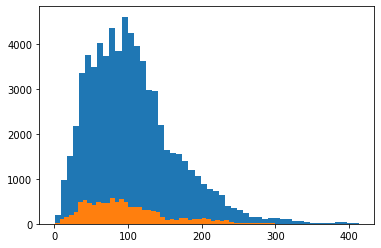

In [86]:
plt.hist(np.abs(oofs_pp['x'].values), bins=50)
plt.hist(np.abs(sub_pp['x'].values), bins=50)
plt.show()

In [84]:
pd.DataFrame(np.abs(oofs_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,69809.0,112.689857,66.305873,0.184819,59.125371,101.573235,159.72145,329.78467


In [85]:
pd.DataFrame(np.abs(sub_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10133.0,100.25362,59.953726,3.3604,53.489666,86.27646,138.38644,285.74164


In [78]:
bad_index = np.union1d(np.where(np.abs(train_df['x'].values - oofs_df['x']) > 20)[0], np.where(np.abs(train_df['y'].values - oofs_df['y']) > 20)[0])

In [92]:
np.save(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_badindex.npy", bad_index)

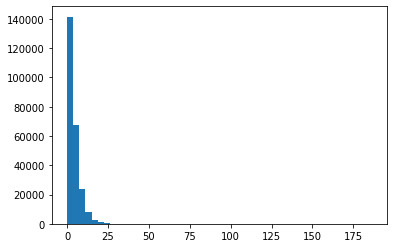

,count,mean,std,min,25%,50%,75%,max
x,245042.0,4.067969,3.780431,0.000015,1.41157,3.084192,5.611626,186.191399


In [76]:
plt.hist(np.abs(train_df['x'].values - oofs_df['x']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['x'].values - oofs_df['x'])).describe().T

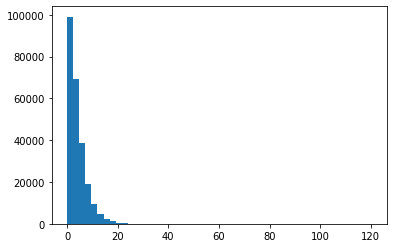

,count,mean,std,min,25%,50%,75%,max
y,245042.0,4.053767,3.723929,0.000053,1.423114,3.092892,5.588755,120.228602


In [77]:
plt.hist(np.abs(train_df['y'].values - oofs_df['y']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['y'].values - oofs_df['y'])).describe().T

In [ ]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

In [ ]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)